In [1]:
import time
import subprocess
from collections import namedtuple,defaultdict
import logging
import json
import os
import yaml
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
import threading
import argparse
import sys
import random
import gym
from torch.utils.tensorboard import SummaryWriter
import copy
import matplotlib.pyplot as plt

In [2]:
class RandomAgent(object):
    """The world's simplest agent!"""

    def __init__(self, env, opt):
        self.opt=opt
        self.env=env
        if opt.fromFile is not None:
            self.load(opt.fromFile)
        self.action_space = env.action_space
        self.featureExtractor = opt.featExtractor(env)

    def act(self, observation, reward, done):
        return self.action_space.sample()

    def save(self,outputDir):
        pass

    def load(self,inputDir):
        pass


In [2]:
from utils import *
from memory import *

# Réseau de neurones

In [3]:
class NN(nn.Module):
    def __init__(self, inSize, outSize, layers=[], func_output=None):
        super(NN, self).__init__()
        self.layers = nn.ModuleList([])
        for x in layers:
            self.layers.append(nn.Linear(inSize, x).double())
            inSize = x
        self.layers.append(nn.Linear(inSize, outSize).double())
        if func_output is not None:
            self.layers.append(nn.Softmax(dim=0).double())

    def setcuda(self, device):
        self.cuda(device=device)

    def forward(self, x):
        x = self.layers[0](x)
        for i in range(1, len(self.layers)):
            x = torch.tanh(x)
            x = self.layers[i](x)
        return x
    
    def parameters(self):
        return [par for layer in self.layers for par in layer.parameters()]

# Policy Gradient

In [4]:
class PolicyGradient:
    def __init__(self,env,insize,layers,config,device, lr_V, lr_Pi, batch_size, discount):
        self.device = device
        self.env = env
        self.action_space = env.action_space.n
        self.V = NN(insize, 1, layers).to(self.device)
        self.Pi = NN(insize, self.action_space, layers, func_output=True).to(self.device)
        self.discount = discount
        self.batch_size = batch_size
        self.optimizer_V = torch.optim.Adam(self.V.parameters(), lr = lr_V)
        self.optimizer_Pi = torch.optim.Adam(self.Pi.parameters(), lr = lr_Pi)
        self.fe = config["featExtractor"](env)
        self.loss_v = torch.nn.SmoothL1Loss()
        self.stateSample = []
        self.nextStateSample = []
        self.rewardSample = []
        self.logProbaSample = []
        self.valueSample = []
        self.nextValueSample = []
        self.rewardArray = []
        self.state = None
        self.cpt = 0

    def act(self, obs, reward, done):
        if self.cpt >= self.batch_size:
            if done: #Une fois qu'on atteint batch_size, on attend la fin de l'épisode avant d'update
                self.update()
        reward = torch.tensor(reward).double()
        obs = torch.tensor(self.fe.getFeatures(obs)).double().to(self.device)
        if self.state is None:
            action = random.randint(0,self.action_space-1)
            self.state = obs
            self.action = torch.tensor(action, dtype=torch.long)
            self.reward = reward
            self.done = done
            return action
        #Sampling de l'action selon Pi
        distribution = torch.distributions.Categorical(probs=self.Pi(obs))
        action = distribution.sample()
        #Calcul de la logproba utilisée dans la loss
        logproba = distribution.log_prob(action)
        #Stockage des différentes informations (état courant, action, value, etc...) utilisées pour l'optimisation
        self.stateSample.append(self.state.clone())
        self.nextStateSample.append(obs)
        self.valueSample.append(self.V(self.state))
        self.nextValueSample.append(self.V(obs))
        self.logProbaSample.append(-1 * logproba)
        self.rewardSample.append(reward)
        self.state = obs
        self.action = action
        self.reward = reward
        self.done = done
        self.cpt += 1
        return action.item()

    def update(self):
        self.cpt = 0
        running_add = 0
        rewardArray = np.zeros(len(self.rewardSample))
        policy_losses = []
        value_losses = []
        #Discounting puis normalisation du reward
        for i in reversed(range(len(self.rewardSample))):
            if self.rewardSample[i] == 0:
                running_add = 0
            running_add = running_add * self.discount + self.rewardSample[i]
            rewardArray[i] = running_add
        rewardArray = (rewardArray - rewardArray.mean()) / rewardArray.std()
        self.nextValueSample = torch.stack(self.nextValueSample).flatten()
        self.valueSample = torch.stack(self.valueSample).flatten()
        self.logProbaSample = torch.stack(self.logProbaSample)
        rewardArray = torch.from_numpy(rewardArray).to(self.device)
        #Calcul de la fonction avantage
        advantage = rewardArray + self.discount * self.nextValueSample - self.valueSample
        #Calcul de la policy loss ainsi que de la value loss (calculs vectorisés)
        policy_losses = self.logProbaSample * advantage
        value_losses = self.loss_v(self.valueSample, rewardArray)
        self.optimizer_V.zero_grad()
        self.optimizer_Pi.zero_grad()
        loss = policy_losses.double().sum() + value_losses.double().sum()
        loss.backward()
        #Optimisation de V et de Pi
        self.optimizer_V.step()
        self.optimizer_Pi.step()
        #Réinitialisation des listes
        self.stateSample = []
        self.nextStateSample = []
        self.rewardSample = []
        self.logProbaSample = []
        self.valueSample = []
        self.nextValueSample = []
        self.rewardArray = []
        return

In [5]:
def runPolicyGradient(config,device,nb_epochs, layers=[30,30], lr_V=0.001, lr_Pi=0.001, batch_size=1000, discount=0.99):
    envName = config["env"]
    if envName == "CartPole-v1":
        insize = 4
    if envName == "LunarLander-v2":
        insize = 8
    freqTest = 10
    freqSave = config["freqSave"]
    nbTest = 100
    env = gym.make(config["env"])
    if hasattr(env, 'setPlan'):
        env.setPlan(config["map"], config["rewards"])
    tstart = str(time.time())
    tstart = tstart.replace(".", "_")
    outdir = "./XP/" + config["env"] + "/random_" + "-" + tstart
    env.seed(config["seed"])
    np.random.seed(config["seed"])
    torch.manual_seed(config["seed"])
    episode_count = config["nbEpisodes"]
    ob = env.reset()
    agent = PolicyGradient(env, batch_size=batch_size, discount=discount, insize=insize,layers=layers, lr_V = lr_V, lr_Pi = lr_Pi, config=config, device=device)
    print("Saving in " + outdir)
    os.makedirs(outdir, exist_ok=True)
    save_src(os.path.abspath(outdir))
    write_yaml(os.path.join(outdir, 'info.yaml'), config)
    logger = LogMe(SummaryWriter(outdir))
    loadTensorBoard(outdir)
    rsum = 0
    mean = 0
    verbose = True
    itest = 0
    reward = 0
    done = False
    arrReward = []
    arrMeanReward = []
    for i in range(nb_epochs):
        if i % int(config["freqVerbose"]) == 0 and i >= config["freqVerbose"]:
            verbose = False
        else:
            verbose = False
        if i % freqTest == 0 and i >= freqTest:  ##### Same as train for now
            print("End of test, mean reward over the last {} actions: {}".format(nbTest,mean / nbTest))
            arrMeanReward.append(mean / nbTest)
            itest += 1
            print("New test time! ")
            mean = 0
            #agent.test = True

        """if i % freqTest == nbTest and i > freqTest:
            #logger.direct_write("rewardTest", mean / nbTest, itest)
            agent.test = False"""
            
        """if i % freqSave == 0:
            agent.save(outdir + "/save_" + str(i))"""

        j = 0
        if verbose:
            env.render()

        while True:
            if verbose:
                env.render()

            action = agent.act(ob, reward, done)
            ob, reward, done, _ = env.step(action)
            j+=1

            rsum += reward
            if done:
                reward = 0
                print(str(i) + " rsum=" + str(rsum) + ", " + str(j) + " actions ")
                #logger.direct_write("reward", rsum, i)
                arrReward.append(rsum)
                agent.nbEvents = 0
                mean += rsum
                rsum = 0
                ob = env.reset()
                break
    env.close()
    plt.plot([i for i in range(len(arrReward))],arrReward,label="Reward")
    plt.plot([i*nbTest for i in range(1,itest+1)],arrMeanReward,label="Mean reward over {} epochs".format(nbTest))
    plt.xlabel("Epoch")
    plt.ylabel("Reward")
    plt.title("Algorithme Actor-Critic, monde {}".format(envName))
    plt.legend()
    plt.show()
    return agent, arrReward, arrMeanReward

# Campagne d'expérimentations

Saving in ./XP/CartPole-v1/random_-1610630325_1028676
tensorboard --logdir=./XP/CartPole-v1/random_-1610630325_1028676
0 rsum=22.0, 22 actions 
1 rsum=14.0, 14 actions 
2 rsum=19.0, 19 actions 
3 rsum=17.0, 17 actions 
4 rsum=18.0, 18 actions 
5 rsum=30.0, 30 actions 
6 rsum=9.0, 9 actions 
7 rsum=12.0, 12 actions 
8 rsum=49.0, 49 actions 
9 rsum=22.0, 22 actions 
End of test, mean reward over the last 10 actions: 21.2
New test time! 
10 rsum=20.0, 20 actions 
11 rsum=10.0, 10 actions 
12 rsum=52.0, 52 actions 
13 rsum=15.0, 15 actions 
14 rsum=13.0, 13 actions 
15 rsum=15.0, 15 actions 
16 rsum=14.0, 14 actions 
17 rsum=15.0, 15 actions 
18 rsum=13.0, 13 actions 
19 rsum=16.0, 16 actions 
End of test, mean reward over the last 10 actions: 18.3
New test time! 
20 rsum=9.0, 9 actions 
21 rsum=16.0, 16 actions 
22 rsum=41.0, 41 actions 
23 rsum=18.0, 18 actions 
24 rsum=9.0, 9 actions 
25 rsum=10.0, 10 actions 
26 rsum=11.0, 11 actions 
27 rsum=18.0, 18 actions 
28 rsum=21.0, 21 actions 

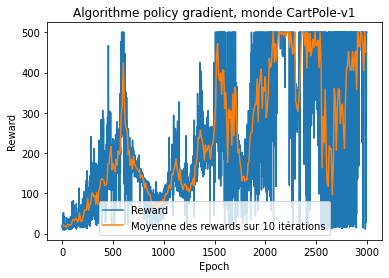

In [7]:
#config = load_yaml('TME4env/configs/config_random_gridworld.yaml')
config = load_yaml('TME4env/configs/config_random_cartpole.yaml')
#config = load_yaml('TME4env/configs/config_random_lunar.yaml')
device = torch.device('cpu')
nb_epochs = 3000
agent, arrReward, arrMeanReward = runPolicyGradient(config, device, nb_epochs, layers=[64,32], lr_V=0.01, lr_Pi=0.01, batch_size=2000, discount=0.99)

Saving in ./XP/CartPole-v1/random_-1614552757_4646034
tensorboard --logdir=./XP/CartPole-v1/random_-1614552757_4646034
0 rsum=14.0, 14 actions 
1 rsum=15.0, 15 actions 
2 rsum=12.0, 12 actions 
3 rsum=48.0, 48 actions 
4 rsum=17.0, 17 actions 
5 rsum=19.0, 19 actions 
6 rsum=10.0, 10 actions 
7 rsum=53.0, 53 actions 
8 rsum=25.0, 25 actions 
9 rsum=15.0, 15 actions 
End of test, mean reward over the last 100 actions: 2.28
New test time! 
10 rsum=10.0, 10 actions 
11 rsum=47.0, 47 actions 
12 rsum=81.0, 81 actions 
13 rsum=12.0, 12 actions 
14 rsum=24.0, 24 actions 
15 rsum=24.0, 24 actions 
16 rsum=18.0, 18 actions 
17 rsum=16.0, 16 actions 
18 rsum=29.0, 29 actions 
19 rsum=14.0, 14 actions 
End of test, mean reward over the last 100 actions: 2.75
New test time! 
20 rsum=30.0, 30 actions 
21 rsum=22.0, 22 actions 
22 rsum=23.0, 23 actions 
23 rsum=27.0, 27 actions 
24 rsum=12.0, 12 actions 
25 rsum=13.0, 13 actions 
26 rsum=14.0, 14 actions 
27 rsum=11.0, 11 actions 
28 rsum=29.0, 29 

243 rsum=123.0, 123 actions 
244 rsum=71.0, 71 actions 
245 rsum=52.0, 52 actions 
246 rsum=75.0, 75 actions 
247 rsum=60.0, 60 actions 
248 rsum=58.0, 58 actions 
249 rsum=29.0, 29 actions 
End of test, mean reward over the last 100 actions: 6.58
New test time! 
250 rsum=62.0, 62 actions 
251 rsum=44.0, 44 actions 
252 rsum=92.0, 92 actions 
253 rsum=84.0, 84 actions 
254 rsum=56.0, 56 actions 
255 rsum=44.0, 44 actions 
256 rsum=66.0, 66 actions 
257 rsum=27.0, 27 actions 
258 rsum=38.0, 38 actions 
259 rsum=16.0, 16 actions 
End of test, mean reward over the last 100 actions: 5.29
New test time! 
260 rsum=60.0, 60 actions 
261 rsum=124.0, 124 actions 
262 rsum=117.0, 117 actions 
263 rsum=82.0, 82 actions 
264 rsum=41.0, 41 actions 
265 rsum=35.0, 35 actions 
266 rsum=175.0, 175 actions 
267 rsum=86.0, 86 actions 
268 rsum=29.0, 29 actions 
269 rsum=79.0, 79 actions 
End of test, mean reward over the last 100 actions: 8.28
New test time! 
270 rsum=192.0, 192 actions 
271 rsum=108.0,

473 rsum=193.0, 193 actions 
474 rsum=187.0, 187 actions 
475 rsum=151.0, 151 actions 
476 rsum=238.0, 238 actions 
477 rsum=267.0, 267 actions 
478 rsum=281.0, 281 actions 
479 rsum=199.0, 199 actions 
End of test, mean reward over the last 100 actions: 21.61
New test time! 
480 rsum=191.0, 191 actions 
481 rsum=239.0, 239 actions 
482 rsum=414.0, 414 actions 
483 rsum=332.0, 332 actions 
484 rsum=210.0, 210 actions 
485 rsum=177.0, 177 actions 
486 rsum=391.0, 391 actions 
487 rsum=162.0, 162 actions 
488 rsum=233.0, 233 actions 
489 rsum=343.0, 343 actions 
End of test, mean reward over the last 100 actions: 26.92
New test time! 
490 rsum=225.0, 225 actions 
491 rsum=184.0, 184 actions 
492 rsum=219.0, 219 actions 
493 rsum=160.0, 160 actions 
494 rsum=217.0, 217 actions 
495 rsum=206.0, 206 actions 
496 rsum=224.0, 224 actions 
497 rsum=231.0, 231 actions 
498 rsum=327.0, 327 actions 
499 rsum=327.0, 327 actions 
End of test, mean reward over the last 100 actions: 23.2
New test tim

700 rsum=189.0, 189 actions 
701 rsum=214.0, 214 actions 
702 rsum=179.0, 179 actions 
703 rsum=212.0, 212 actions 
704 rsum=223.0, 223 actions 
705 rsum=257.0, 257 actions 
706 rsum=181.0, 181 actions 
707 rsum=188.0, 188 actions 
708 rsum=366.0, 366 actions 
709 rsum=189.0, 189 actions 
End of test, mean reward over the last 100 actions: 21.98
New test time! 
710 rsum=168.0, 168 actions 
711 rsum=192.0, 192 actions 
712 rsum=179.0, 179 actions 
713 rsum=212.0, 212 actions 
714 rsum=172.0, 172 actions 
715 rsum=200.0, 200 actions 
716 rsum=141.0, 141 actions 
717 rsum=167.0, 167 actions 
718 rsum=188.0, 188 actions 
719 rsum=195.0, 195 actions 
End of test, mean reward over the last 100 actions: 18.14
New test time! 
720 rsum=169.0, 169 actions 
721 rsum=276.0, 276 actions 
722 rsum=198.0, 198 actions 
723 rsum=52.0, 52 actions 
724 rsum=188.0, 188 actions 
725 rsum=243.0, 243 actions 
726 rsum=153.0, 153 actions 
727 rsum=191.0, 191 actions 
728 rsum=191.0, 191 actions 
729 rsum=160.

929 rsum=231.0, 231 actions 
End of test, mean reward over the last 100 actions: 19.44
New test time! 
930 rsum=236.0, 236 actions 
931 rsum=243.0, 243 actions 
932 rsum=230.0, 230 actions 
933 rsum=180.0, 180 actions 
934 rsum=213.0, 213 actions 
935 rsum=266.0, 266 actions 
936 rsum=210.0, 210 actions 
937 rsum=176.0, 176 actions 
938 rsum=215.0, 215 actions 
939 rsum=210.0, 210 actions 
End of test, mean reward over the last 100 actions: 21.79
New test time! 
940 rsum=211.0, 211 actions 
941 rsum=233.0, 233 actions 
942 rsum=258.0, 258 actions 
943 rsum=253.0, 253 actions 
944 rsum=271.0, 271 actions 
945 rsum=220.0, 220 actions 
946 rsum=192.0, 192 actions 
947 rsum=270.0, 270 actions 
948 rsum=231.0, 231 actions 
949 rsum=263.0, 263 actions 
End of test, mean reward over the last 100 actions: 24.02
New test time! 
950 rsum=252.0, 252 actions 
951 rsum=282.0, 282 actions 
952 rsum=251.0, 251 actions 
953 rsum=286.0, 286 actions 
954 rsum=302.0, 302 actions 
955 rsum=260.0, 260 acti

1150 rsum=500.0, 500 actions 
1151 rsum=500.0, 500 actions 
1152 rsum=182.0, 182 actions 
1153 rsum=500.0, 500 actions 
1154 rsum=500.0, 500 actions 
1155 rsum=500.0, 500 actions 
1156 rsum=133.0, 133 actions 
1157 rsum=190.0, 190 actions 
1158 rsum=304.0, 304 actions 
1159 rsum=500.0, 500 actions 
End of test, mean reward over the last 100 actions: 38.09
New test time! 
1160 rsum=500.0, 500 actions 
1161 rsum=500.0, 500 actions 
1162 rsum=254.0, 254 actions 
1163 rsum=500.0, 500 actions 
1164 rsum=198.0, 198 actions 
1165 rsum=500.0, 500 actions 
1166 rsum=500.0, 500 actions 
1167 rsum=500.0, 500 actions 
1168 rsum=284.0, 284 actions 
1169 rsum=201.0, 201 actions 
End of test, mean reward over the last 100 actions: 39.37
New test time! 
1170 rsum=500.0, 500 actions 
1171 rsum=500.0, 500 actions 
1172 rsum=237.0, 237 actions 
1173 rsum=500.0, 500 actions 
1174 rsum=214.0, 214 actions 
1175 rsum=500.0, 500 actions 
1176 rsum=500.0, 500 actions 
1177 rsum=500.0, 500 actions 
1178 rsum=50

1370 rsum=500.0, 500 actions 
1371 rsum=500.0, 500 actions 
1372 rsum=500.0, 500 actions 
1373 rsum=500.0, 500 actions 
1374 rsum=174.0, 174 actions 
1375 rsum=500.0, 500 actions 
1376 rsum=500.0, 500 actions 
1377 rsum=500.0, 500 actions 
1378 rsum=500.0, 500 actions 
1379 rsum=500.0, 500 actions 
End of test, mean reward over the last 100 actions: 46.74
New test time! 
1380 rsum=500.0, 500 actions 
1381 rsum=500.0, 500 actions 
1382 rsum=500.0, 500 actions 
1383 rsum=500.0, 500 actions 
1384 rsum=500.0, 500 actions 
1385 rsum=500.0, 500 actions 
1386 rsum=500.0, 500 actions 
1387 rsum=500.0, 500 actions 
1388 rsum=500.0, 500 actions 
1389 rsum=500.0, 500 actions 
End of test, mean reward over the last 100 actions: 50.0
New test time! 
1390 rsum=500.0, 500 actions 
1391 rsum=500.0, 500 actions 
1392 rsum=500.0, 500 actions 
1393 rsum=500.0, 500 actions 
1394 rsum=500.0, 500 actions 
1395 rsum=361.0, 361 actions 
1396 rsum=500.0, 500 actions 
1397 rsum=401.0, 401 actions 
1398 rsum=500

1590 rsum=401.0, 401 actions 
1591 rsum=500.0, 500 actions 
1592 rsum=500.0, 500 actions 
1593 rsum=500.0, 500 actions 
1594 rsum=500.0, 500 actions 
1595 rsum=466.0, 466 actions 
1596 rsum=500.0, 500 actions 
1597 rsum=297.0, 297 actions 
1598 rsum=137.0, 137 actions 
1599 rsum=500.0, 500 actions 
End of test, mean reward over the last 100 actions: 43.01
New test time! 
1600 rsum=500.0, 500 actions 
1601 rsum=164.0, 164 actions 
1602 rsum=49.0, 49 actions 
1603 rsum=304.0, 304 actions 
1604 rsum=146.0, 146 actions 
1605 rsum=167.0, 167 actions 
1606 rsum=500.0, 500 actions 
1607 rsum=386.0, 386 actions 
1608 rsum=153.0, 153 actions 
1609 rsum=500.0, 500 actions 
End of test, mean reward over the last 100 actions: 28.69
New test time! 
1610 rsum=150.0, 150 actions 
1611 rsum=127.0, 127 actions 
1612 rsum=500.0, 500 actions 
1613 rsum=90.0, 90 actions 
1614 rsum=500.0, 500 actions 
1615 rsum=134.0, 134 actions 
1616 rsum=172.0, 172 actions 
1617 rsum=165.0, 165 actions 
1618 rsum=178.0,

1810 rsum=369.0, 369 actions 
1811 rsum=390.0, 390 actions 
1812 rsum=258.0, 258 actions 
1813 rsum=349.0, 349 actions 
1814 rsum=222.0, 222 actions 
1815 rsum=393.0, 393 actions 
1816 rsum=459.0, 459 actions 
1817 rsum=395.0, 395 actions 
1818 rsum=367.0, 367 actions 
1819 rsum=394.0, 394 actions 
End of test, mean reward over the last 100 actions: 35.96
New test time! 
1820 rsum=384.0, 384 actions 
1821 rsum=318.0, 318 actions 
1822 rsum=333.0, 333 actions 
1823 rsum=359.0, 359 actions 
1824 rsum=328.0, 328 actions 
1825 rsum=436.0, 436 actions 
1826 rsum=284.0, 284 actions 
1827 rsum=330.0, 330 actions 
1828 rsum=500.0, 500 actions 
1829 rsum=365.0, 365 actions 
End of test, mean reward over the last 100 actions: 36.37
New test time! 
1830 rsum=208.0, 208 actions 
1831 rsum=267.0, 267 actions 
1832 rsum=353.0, 353 actions 
1833 rsum=258.0, 258 actions 
1834 rsum=488.0, 488 actions 
1835 rsum=340.0, 340 actions 
1836 rsum=262.0, 262 actions 
1837 rsum=383.0, 383 actions 
1838 rsum=18

2030 rsum=260.0, 260 actions 
2031 rsum=161.0, 161 actions 
2032 rsum=137.0, 137 actions 
2033 rsum=118.0, 118 actions 
2034 rsum=147.0, 147 actions 
2035 rsum=167.0, 167 actions 
2036 rsum=213.0, 213 actions 
2037 rsum=123.0, 123 actions 
2038 rsum=131.0, 131 actions 
2039 rsum=159.0, 159 actions 
End of test, mean reward over the last 100 actions: 16.16
New test time! 
2040 rsum=162.0, 162 actions 
2041 rsum=141.0, 141 actions 
2042 rsum=240.0, 240 actions 
2043 rsum=195.0, 195 actions 
2044 rsum=155.0, 155 actions 
2045 rsum=106.0, 106 actions 
2046 rsum=167.0, 167 actions 
2047 rsum=175.0, 175 actions 
2048 rsum=296.0, 296 actions 
2049 rsum=169.0, 169 actions 
End of test, mean reward over the last 100 actions: 18.06
New test time! 
2050 rsum=165.0, 165 actions 
2051 rsum=187.0, 187 actions 
2052 rsum=184.0, 184 actions 
2053 rsum=150.0, 150 actions 
2054 rsum=211.0, 211 actions 
2055 rsum=242.0, 242 actions 
2056 rsum=161.0, 161 actions 
2057 rsum=163.0, 163 actions 
2058 rsum=23

2250 rsum=143.0, 143 actions 
2251 rsum=135.0, 135 actions 
2252 rsum=114.0, 114 actions 
2253 rsum=64.0, 64 actions 
2254 rsum=118.0, 118 actions 
2255 rsum=109.0, 109 actions 
2256 rsum=134.0, 134 actions 
2257 rsum=119.0, 119 actions 
2258 rsum=141.0, 141 actions 
2259 rsum=113.0, 113 actions 
End of test, mean reward over the last 100 actions: 11.9
New test time! 
2260 rsum=112.0, 112 actions 
2261 rsum=117.0, 117 actions 
2262 rsum=127.0, 127 actions 
2263 rsum=139.0, 139 actions 
2264 rsum=115.0, 115 actions 
2265 rsum=121.0, 121 actions 
2266 rsum=115.0, 115 actions 
2267 rsum=119.0, 119 actions 
2268 rsum=112.0, 112 actions 
2269 rsum=140.0, 140 actions 
End of test, mean reward over the last 100 actions: 12.17
New test time! 
2270 rsum=105.0, 105 actions 
2271 rsum=120.0, 120 actions 
2272 rsum=100.0, 100 actions 
2273 rsum=99.0, 99 actions 
2274 rsum=146.0, 146 actions 
2275 rsum=103.0, 103 actions 
2276 rsum=123.0, 123 actions 
2277 rsum=109.0, 109 actions 
2278 rsum=112.0, 

2481 rsum=100.0, 100 actions 
2482 rsum=85.0, 85 actions 
2483 rsum=102.0, 102 actions 
2484 rsum=89.0, 89 actions 
2485 rsum=93.0, 93 actions 
2486 rsum=82.0, 82 actions 
2487 rsum=90.0, 90 actions 
2488 rsum=58.0, 58 actions 
2489 rsum=83.0, 83 actions 
End of test, mean reward over the last 100 actions: 8.6
New test time! 
2490 rsum=58.0, 58 actions 
2491 rsum=86.0, 86 actions 
2492 rsum=93.0, 93 actions 
2493 rsum=75.0, 75 actions 
2494 rsum=91.0, 91 actions 
2495 rsum=90.0, 90 actions 
2496 rsum=35.0, 35 actions 
2497 rsum=84.0, 84 actions 
2498 rsum=86.0, 86 actions 
2499 rsum=81.0, 81 actions 
End of test, mean reward over the last 100 actions: 7.79
New test time! 
2500 rsum=98.0, 98 actions 
2501 rsum=86.0, 86 actions 
2502 rsum=123.0, 123 actions 
2503 rsum=79.0, 79 actions 
2504 rsum=100.0, 100 actions 
2505 rsum=118.0, 118 actions 
2506 rsum=17.0, 17 actions 
2507 rsum=79.0, 79 actions 
2508 rsum=94.0, 94 actions 
2509 rsum=83.0, 83 actions 
End of test, mean reward over the

2708 rsum=146.0, 146 actions 
2709 rsum=119.0, 119 actions 
End of test, mean reward over the last 100 actions: 13.18
New test time! 
2710 rsum=116.0, 116 actions 
2711 rsum=132.0, 132 actions 
2712 rsum=122.0, 122 actions 
2713 rsum=147.0, 147 actions 
2714 rsum=124.0, 124 actions 
2715 rsum=133.0, 133 actions 
2716 rsum=120.0, 120 actions 
2717 rsum=121.0, 121 actions 
2718 rsum=104.0, 104 actions 
2719 rsum=159.0, 159 actions 
End of test, mean reward over the last 100 actions: 12.78
New test time! 
2720 rsum=127.0, 127 actions 
2721 rsum=125.0, 125 actions 
2722 rsum=118.0, 118 actions 
2723 rsum=136.0, 136 actions 
2724 rsum=35.0, 35 actions 
2725 rsum=127.0, 127 actions 
2726 rsum=132.0, 132 actions 
2727 rsum=132.0, 132 actions 
2728 rsum=135.0, 135 actions 
2729 rsum=134.0, 134 actions 
End of test, mean reward over the last 100 actions: 12.01
New test time! 
2730 rsum=121.0, 121 actions 
2731 rsum=79.0, 79 actions 
2732 rsum=120.0, 120 actions 
2733 rsum=114.0, 114 actions 
27

2929 rsum=113.0, 113 actions 
End of test, mean reward over the last 100 actions: 11.31
New test time! 
2930 rsum=95.0, 95 actions 
2931 rsum=114.0, 114 actions 
2932 rsum=120.0, 120 actions 
2933 rsum=106.0, 106 actions 
2934 rsum=129.0, 129 actions 
2935 rsum=118.0, 118 actions 
2936 rsum=119.0, 119 actions 
2937 rsum=107.0, 107 actions 
2938 rsum=130.0, 130 actions 
2939 rsum=124.0, 124 actions 
End of test, mean reward over the last 100 actions: 11.62
New test time! 
2940 rsum=131.0, 131 actions 
2941 rsum=108.0, 108 actions 
2942 rsum=110.0, 110 actions 
2943 rsum=107.0, 107 actions 
2944 rsum=118.0, 118 actions 
2945 rsum=116.0, 116 actions 
2946 rsum=121.0, 121 actions 
2947 rsum=77.0, 77 actions 
2948 rsum=46.0, 46 actions 
2949 rsum=108.0, 108 actions 
End of test, mean reward over the last 100 actions: 10.42
New test time! 
2950 rsum=106.0, 106 actions 
2951 rsum=118.0, 118 actions 
2952 rsum=110.0, 110 actions 
2953 rsum=107.0, 107 actions 
2954 rsum=121.0, 121 actions 
2955

3150 rsum=147.0, 147 actions 
3151 rsum=190.0, 190 actions 
3152 rsum=156.0, 156 actions 
3153 rsum=140.0, 140 actions 
3154 rsum=208.0, 208 actions 
3155 rsum=198.0, 198 actions 
3156 rsum=179.0, 179 actions 
3157 rsum=185.0, 185 actions 
3158 rsum=183.0, 183 actions 
3159 rsum=209.0, 209 actions 
End of test, mean reward over the last 100 actions: 17.95
New test time! 
3160 rsum=160.0, 160 actions 
3161 rsum=162.0, 162 actions 
3162 rsum=183.0, 183 actions 
3163 rsum=167.0, 167 actions 
3164 rsum=175.0, 175 actions 
3165 rsum=146.0, 146 actions 
3166 rsum=207.0, 207 actions 
3167 rsum=165.0, 165 actions 
3168 rsum=188.0, 188 actions 
3169 rsum=185.0, 185 actions 
End of test, mean reward over the last 100 actions: 17.38
New test time! 
3170 rsum=254.0, 254 actions 
3171 rsum=186.0, 186 actions 
3172 rsum=199.0, 199 actions 
3173 rsum=149.0, 149 actions 
3174 rsum=179.0, 179 actions 
3175 rsum=171.0, 171 actions 
3176 rsum=350.0, 350 actions 
3177 rsum=173.0, 173 actions 
3178 rsum=14

3370 rsum=473.0, 473 actions 
3371 rsum=477.0, 477 actions 
3372 rsum=500.0, 500 actions 
3373 rsum=300.0, 300 actions 
3374 rsum=408.0, 408 actions 
3375 rsum=366.0, 366 actions 
3376 rsum=419.0, 419 actions 
3377 rsum=348.0, 348 actions 
3378 rsum=351.0, 351 actions 
3379 rsum=387.0, 387 actions 
End of test, mean reward over the last 100 actions: 40.29
New test time! 
3380 rsum=483.0, 483 actions 
3381 rsum=272.0, 272 actions 
3382 rsum=282.0, 282 actions 
3383 rsum=332.0, 332 actions 
3384 rsum=334.0, 334 actions 
3385 rsum=316.0, 316 actions 
3386 rsum=344.0, 344 actions 
3387 rsum=297.0, 297 actions 
3388 rsum=71.0, 71 actions 
3389 rsum=491.0, 491 actions 
End of test, mean reward over the last 100 actions: 32.22
New test time! 
3390 rsum=496.0, 496 actions 
3391 rsum=401.0, 401 actions 
3392 rsum=363.0, 363 actions 
3393 rsum=434.0, 434 actions 
3394 rsum=422.0, 422 actions 
3395 rsum=380.0, 380 actions 
3396 rsum=500.0, 500 actions 
3397 rsum=247.0, 247 actions 
3398 rsum=412.

3590 rsum=500.0, 500 actions 
3591 rsum=500.0, 500 actions 
3592 rsum=329.0, 329 actions 
3593 rsum=500.0, 500 actions 
3594 rsum=500.0, 500 actions 
3595 rsum=500.0, 500 actions 
3596 rsum=500.0, 500 actions 
3597 rsum=500.0, 500 actions 
3598 rsum=500.0, 500 actions 
3599 rsum=500.0, 500 actions 
End of test, mean reward over the last 100 actions: 48.29
New test time! 
3600 rsum=500.0, 500 actions 
3601 rsum=500.0, 500 actions 
3602 rsum=500.0, 500 actions 
3603 rsum=208.0, 208 actions 
3604 rsum=500.0, 500 actions 
3605 rsum=500.0, 500 actions 
3606 rsum=500.0, 500 actions 
3607 rsum=500.0, 500 actions 
3608 rsum=40.0, 40 actions 
3609 rsum=500.0, 500 actions 
End of test, mean reward over the last 100 actions: 42.48
New test time! 
3610 rsum=500.0, 500 actions 
3611 rsum=500.0, 500 actions 
3612 rsum=500.0, 500 actions 
3613 rsum=500.0, 500 actions 
3614 rsum=500.0, 500 actions 
3615 rsum=500.0, 500 actions 
3616 rsum=500.0, 500 actions 
3617 rsum=500.0, 500 actions 
3618 rsum=500.

3813 rsum=187.0, 187 actions 
3814 rsum=180.0, 180 actions 
3815 rsum=195.0, 195 actions 
3816 rsum=20.0, 20 actions 
3817 rsum=12.0, 12 actions 
3818 rsum=181.0, 181 actions 
3819 rsum=15.0, 15 actions 
End of test, mean reward over the last 100 actions: 13.82
New test time! 
3820 rsum=173.0, 173 actions 
3821 rsum=182.0, 182 actions 
3822 rsum=188.0, 188 actions 
3823 rsum=174.0, 174 actions 
3824 rsum=179.0, 179 actions 
3825 rsum=173.0, 173 actions 
3826 rsum=173.0, 173 actions 
3827 rsum=159.0, 159 actions 
3828 rsum=158.0, 158 actions 
3829 rsum=152.0, 152 actions 
End of test, mean reward over the last 100 actions: 17.11
New test time! 
3830 rsum=174.0, 174 actions 
3831 rsum=24.0, 24 actions 
3832 rsum=18.0, 18 actions 
3833 rsum=167.0, 167 actions 
3834 rsum=171.0, 171 actions 
3835 rsum=184.0, 184 actions 
3836 rsum=169.0, 169 actions 
3837 rsum=162.0, 162 actions 
3838 rsum=169.0, 169 actions 
3839 rsum=162.0, 162 actions 
End of test, mean reward over the last 100 actions: 

4036 rsum=176.0, 176 actions 
4037 rsum=165.0, 165 actions 
4038 rsum=162.0, 162 actions 
4039 rsum=201.0, 201 actions 
End of test, mean reward over the last 100 actions: 16.89
New test time! 
4040 rsum=30.0, 30 actions 
4041 rsum=153.0, 153 actions 
4042 rsum=169.0, 169 actions 
4043 rsum=186.0, 186 actions 
4044 rsum=180.0, 180 actions 
4045 rsum=177.0, 177 actions 
4046 rsum=167.0, 167 actions 
4047 rsum=176.0, 176 actions 
4048 rsum=167.0, 167 actions 
4049 rsum=173.0, 173 actions 
End of test, mean reward over the last 100 actions: 15.78
New test time! 
4050 rsum=176.0, 176 actions 
4051 rsum=191.0, 191 actions 
4052 rsum=172.0, 172 actions 
4053 rsum=173.0, 173 actions 
4054 rsum=176.0, 176 actions 
4055 rsum=181.0, 181 actions 
4056 rsum=172.0, 172 actions 
4057 rsum=180.0, 180 actions 
4058 rsum=185.0, 185 actions 
4059 rsum=24.0, 24 actions 
End of test, mean reward over the last 100 actions: 16.3
New test time! 
4060 rsum=177.0, 177 actions 
4061 rsum=167.0, 167 actions 
406

4256 rsum=500.0, 500 actions 
4257 rsum=500.0, 500 actions 
4258 rsum=500.0, 500 actions 
4259 rsum=500.0, 500 actions 
End of test, mean reward over the last 100 actions: 50.0
New test time! 
4260 rsum=500.0, 500 actions 
4261 rsum=500.0, 500 actions 
4262 rsum=500.0, 500 actions 
4263 rsum=500.0, 500 actions 
4264 rsum=421.0, 421 actions 
4265 rsum=500.0, 500 actions 
4266 rsum=500.0, 500 actions 
4267 rsum=500.0, 500 actions 
4268 rsum=500.0, 500 actions 
4269 rsum=500.0, 500 actions 
End of test, mean reward over the last 100 actions: 49.21
New test time! 
4270 rsum=500.0, 500 actions 
4271 rsum=500.0, 500 actions 
4272 rsum=500.0, 500 actions 
4273 rsum=500.0, 500 actions 
4274 rsum=500.0, 500 actions 
4275 rsum=500.0, 500 actions 
4276 rsum=18.0, 18 actions 
4277 rsum=500.0, 500 actions 
4278 rsum=217.0, 217 actions 
4279 rsum=500.0, 500 actions 
End of test, mean reward over the last 100 actions: 42.35
New test time! 
4280 rsum=500.0, 500 actions 
4281 rsum=248.0, 248 actions 
4

4477 rsum=274.0, 274 actions 
4478 rsum=423.0, 423 actions 
4479 rsum=382.0, 382 actions 
End of test, mean reward over the last 100 actions: 32.66
New test time! 
4480 rsum=387.0, 387 actions 
4481 rsum=359.0, 359 actions 
4482 rsum=451.0, 451 actions 
4483 rsum=322.0, 322 actions 
4484 rsum=441.0, 441 actions 
4485 rsum=326.0, 326 actions 
4486 rsum=297.0, 297 actions 
4487 rsum=351.0, 351 actions 
4488 rsum=385.0, 385 actions 
4489 rsum=309.0, 309 actions 
End of test, mean reward over the last 100 actions: 36.28
New test time! 
4490 rsum=288.0, 288 actions 
4491 rsum=127.0, 127 actions 
4492 rsum=338.0, 338 actions 
4493 rsum=321.0, 321 actions 
4494 rsum=322.0, 322 actions 
4495 rsum=299.0, 299 actions 
4496 rsum=348.0, 348 actions 
4497 rsum=46.0, 46 actions 
4498 rsum=255.0, 255 actions 
4499 rsum=279.0, 279 actions 
End of test, mean reward over the last 100 actions: 26.23
New test time! 
4500 rsum=272.0, 272 actions 
4501 rsum=229.0, 229 actions 
4502 rsum=236.0, 236 actions 


4698 rsum=146.0, 146 actions 
4699 rsum=153.0, 153 actions 
End of test, mean reward over the last 100 actions: 13.94
New test time! 
4700 rsum=151.0, 151 actions 
4701 rsum=157.0, 157 actions 
4702 rsum=142.0, 142 actions 
4703 rsum=122.0, 122 actions 
4704 rsum=130.0, 130 actions 
4705 rsum=140.0, 140 actions 
4706 rsum=124.0, 124 actions 
4707 rsum=32.0, 32 actions 
4708 rsum=152.0, 152 actions 
4709 rsum=135.0, 135 actions 
End of test, mean reward over the last 100 actions: 12.85
New test time! 
4710 rsum=144.0, 144 actions 
4711 rsum=136.0, 136 actions 
4712 rsum=143.0, 143 actions 
4713 rsum=38.0, 38 actions 
4714 rsum=137.0, 137 actions 
4715 rsum=127.0, 127 actions 
4716 rsum=128.0, 128 actions 
4717 rsum=144.0, 144 actions 
4718 rsum=143.0, 143 actions 
4719 rsum=134.0, 134 actions 
End of test, mean reward over the last 100 actions: 12.74
New test time! 
4720 rsum=28.0, 28 actions 
4721 rsum=137.0, 137 actions 
4722 rsum=32.0, 32 actions 
4723 rsum=35.0, 35 actions 
4724 rsu

4921 rsum=110.0, 110 actions 
4922 rsum=44.0, 44 actions 
4923 rsum=116.0, 116 actions 
4924 rsum=112.0, 112 actions 
4925 rsum=123.0, 123 actions 
4926 rsum=103.0, 103 actions 
4927 rsum=115.0, 115 actions 
4928 rsum=25.0, 25 actions 
4929 rsum=112.0, 112 actions 
End of test, mean reward over the last 100 actions: 9.83
New test time! 
4930 rsum=41.0, 41 actions 
4931 rsum=117.0, 117 actions 
4932 rsum=34.0, 34 actions 
4933 rsum=111.0, 111 actions 
4934 rsum=112.0, 112 actions 
4935 rsum=44.0, 44 actions 
4936 rsum=106.0, 106 actions 
4937 rsum=111.0, 111 actions 
4938 rsum=113.0, 113 actions 
4939 rsum=111.0, 111 actions 
End of test, mean reward over the last 100 actions: 9.0
New test time! 
4940 rsum=114.0, 114 actions 
4941 rsum=117.0, 117 actions 
4942 rsum=27.0, 27 actions 
4943 rsum=117.0, 117 actions 
4944 rsum=31.0, 31 actions 
4945 rsum=22.0, 22 actions 
4946 rsum=120.0, 120 actions 
4947 rsum=13.0, 13 actions 
4948 rsum=126.0, 126 actions 
4949 rsum=107.0, 107 actions 
End

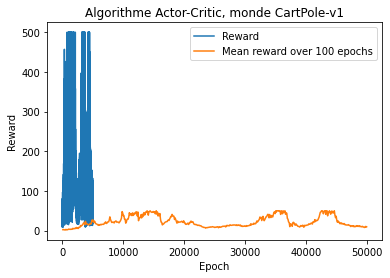

In [7]:
#config = load_yaml('TME4env/configs/config_random_gridworld.yaml')
config = load_yaml('configs/config_random_cartpole.yaml')
#config = load_yaml('TME4env/configs/config_random_lunar.yaml')
device = torch.device('cpu')
nb_epochs = 5000
agent, arrReward, arrMeanReward = runPolicyGradient(config, device, nb_epochs, layers=[64,32], lr_V=0.01, lr_Pi=0.01, batch_size=2000, discount=0.99)

Saving in ./XP/LunarLander-v2/random_-1610630889_324354
tensorboard --logdir=./XP/LunarLander-v2/random_-1610630889_324354
0 rsum=-147.50688808579554, 74 actions 
1 rsum=-89.85429922795768, 69 actions 
2 rsum=-172.2204982250616, 96 actions 
3 rsum=-66.43232668512863, 73 actions 
4 rsum=-438.45455090464975, 104 actions 
5 rsum=-24.378828699892452, 93 actions 
6 rsum=-197.2161303113673, 78 actions 
7 rsum=-86.09696175596164, 65 actions 
8 rsum=-298.35968618595496, 96 actions 
9 rsum=-213.5106822825964, 117 actions 
End of test, mean reward over the last 10 actions: -173.40308523643662
New test time! 
10 rsum=32.531256328124044, 98 actions 
11 rsum=-322.96451984520365, 76 actions 
12 rsum=-110.46855285665929, 99 actions 
13 rsum=-131.55087264940155, 91 actions 
14 rsum=-172.34083850573822, 113 actions 
15 rsum=-107.40165622417578, 114 actions 
16 rsum=-128.98332083437853, 98 actions 
17 rsum=-100.08982304886234, 90 actions 
18 rsum=-200.29856859139554, 93 actions 
19 rsum=-129.88549709895

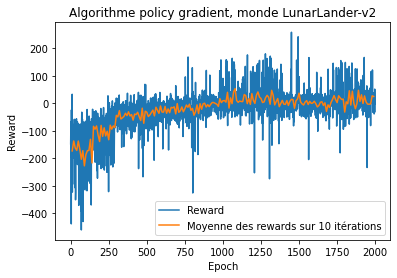

In [8]:
#config = load_yaml('TME4env/configs/config_random_gridworld.yaml')
#config = load_yaml('TME4env/configs/config_random_cartpole.yaml')
config = load_yaml('TME4env/configs/config_random_lunar.yaml')
device = torch.device('cpu')
nb_epochs = 2000
agent, arrReward, arrMeanReward = runPolicyGradient(config, device, nb_epochs, layers=[256,128], lr_V=0.001, lr_Pi=0.001, batch_size=1000, discount=0.99)

In [8]:
#config = load_yaml('TME4env/configs/config_random_gridworld.yaml')
#config = load_yaml('TME4env/configs/config_random_cartpole.yaml')
config = load_yaml('configs/config_random_lunar.yaml')
device = torch.device('cpu')
nb_epochs = 3000
agent, arrReward, arrMeanReward = runPolicyGradient(config, device, nb_epochs, layers=[256,128], lr_V=0.001, lr_Pi=0.001, batch_size=1000, discount=0.99)

AttributeError: module 'gym.envs.box2d' has no attribute 'LunarLander'

Saving in ./XP/LunarLander-v2/random_-1610631414_8445635
tensorboard --logdir=./XP/LunarLander-v2/random_-1610631414_8445635
0 rsum=-200.92871167398746, 85 actions 
1 rsum=-176.56067888854676, 82 actions 
2 rsum=-166.58491660156722, 83 actions 
3 rsum=-210.2321999481219, 112 actions 
4 rsum=-150.46934423917594, 105 actions 
5 rsum=-266.8744107953571, 138 actions 
6 rsum=-113.13408271888322, 95 actions 
7 rsum=-305.8831538333734, 104 actions 
8 rsum=-92.88439808004811, 90 actions 
9 rsum=-259.539527608, 119 actions 
End of test, mean reward over the last 10 actions: -194.30914243870615
New test time! 
10 rsum=-478.15630330896664, 91 actions 
11 rsum=-89.89002642618763, 71 actions 
12 rsum=-108.64424264280984, 102 actions 
13 rsum=-376.202476042476, 129 actions 
14 rsum=-171.33311619885774, 73 actions 
15 rsum=-81.51525471877187, 142 actions 
16 rsum=-432.91061515363765, 83 actions 
17 rsum=-503.05611525575995, 86 actions 
18 rsum=-116.38321374868943, 90 actions 
19 rsum=-122.59702368649

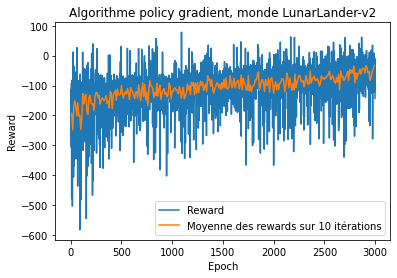

In [9]:
#config = load_yaml('TME4env/configs/config_random_gridworld.yaml')
#config = load_yaml('TME4env/configs/config_random_cartpole.yaml')
config = load_yaml('TME4env/configs/config_random_lunar.yaml')
device = torch.device('cpu')
nb_epochs = 3000
agent, arrReward, arrMeanReward = runPolicyGradient(config, device, nb_epochs, layers=[128,128], lr_V=0.001, lr_Pi=0.001, batch_size=5000, discount=0.99)

Saving in ./XP/CartPole-v1/random_-1610631738_6030898
tensorboard --logdir=./XP/CartPole-v1/random_-1610631738_6030898
0 rsum=14.0, 14 actions 
1 rsum=15.0, 15 actions 
2 rsum=12.0, 12 actions 
3 rsum=48.0, 48 actions 
4 rsum=17.0, 17 actions 
5 rsum=19.0, 19 actions 
6 rsum=10.0, 10 actions 
7 rsum=53.0, 53 actions 
8 rsum=25.0, 25 actions 
9 rsum=15.0, 15 actions 
End of test, mean reward over the last 10 actions: 22.8
New test time! 
10 rsum=10.0, 10 actions 
11 rsum=47.0, 47 actions 
12 rsum=81.0, 81 actions 
13 rsum=12.0, 12 actions 
14 rsum=24.0, 24 actions 
15 rsum=24.0, 24 actions 
16 rsum=18.0, 18 actions 
17 rsum=16.0, 16 actions 
18 rsum=29.0, 29 actions 
19 rsum=14.0, 14 actions 
End of test, mean reward over the last 10 actions: 27.5
New test time! 
20 rsum=30.0, 30 actions 
21 rsum=22.0, 22 actions 
22 rsum=23.0, 23 actions 
23 rsum=27.0, 27 actions 
24 rsum=12.0, 12 actions 
25 rsum=13.0, 13 actions 
26 rsum=14.0, 14 actions 
27 rsum=11.0, 11 actions 
28 rsum=29.0, 29 ac

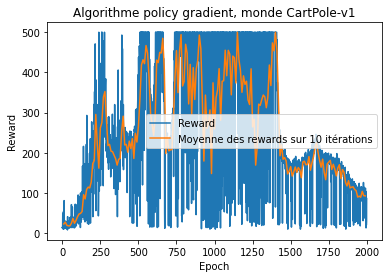

In [10]:
#config = load_yaml('TME4env/configs/config_random_gridworld.yaml')
config = load_yaml('TME4env/configs/config_random_cartpole.yaml')
#config = load_yaml('TME4env/configs/config_random_lunar.yaml')
device = torch.device('cpu')
nb_epochs = 2000
agent, arrReward, arrMeanReward = runPolicyGradient(config, device, nb_epochs, layers=[64,32], lr_V=0.01, lr_Pi=0.01)

Saving in ./XP/CartPole-v1/random_-1610632124_1301425
tensorboard --logdir=./XP/CartPole-v1/random_-1610632124_1301425
0 rsum=14.0, 14 actions 
1 rsum=15.0, 15 actions 
2 rsum=12.0, 12 actions 
3 rsum=48.0, 48 actions 
4 rsum=17.0, 17 actions 
5 rsum=19.0, 19 actions 
6 rsum=10.0, 10 actions 
7 rsum=53.0, 53 actions 
8 rsum=25.0, 25 actions 
9 rsum=15.0, 15 actions 
End of test, mean reward over the last 10 actions: 22.8
New test time! 
10 rsum=10.0, 10 actions 
11 rsum=47.0, 47 actions 
12 rsum=81.0, 81 actions 
13 rsum=12.0, 12 actions 
14 rsum=24.0, 24 actions 
15 rsum=24.0, 24 actions 
16 rsum=18.0, 18 actions 
17 rsum=16.0, 16 actions 
18 rsum=29.0, 29 actions 
19 rsum=14.0, 14 actions 
End of test, mean reward over the last 10 actions: 27.5
New test time! 
20 rsum=30.0, 30 actions 
21 rsum=22.0, 22 actions 
22 rsum=23.0, 23 actions 
23 rsum=27.0, 27 actions 
24 rsum=12.0, 12 actions 
25 rsum=13.0, 13 actions 
26 rsum=14.0, 14 actions 
27 rsum=11.0, 11 actions 
28 rsum=29.0, 29 ac

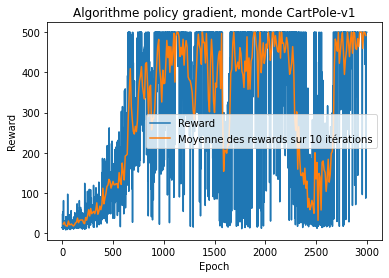

In [11]:
#config = load_yaml('TME4env/configs/config_random_gridworld.yaml')
config = load_yaml('TME4env/configs/config_random_cartpole.yaml')
#config = load_yaml('TME4env/configs/config_random_lunar.yaml')
device = torch.device('cpu')
nb_epochs = 3000
agent, arrReward, arrMeanReward = runPolicyGradient(config, device, nb_epochs, layers=[64,32], lr_V=0.01, lr_Pi=0.01, batch_size=3000, discount=0.99)